In [4]:
import numpy as np
import csv
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from random import sample

data_path = Path('data/')
data_path = Path('../../../data/')

data_path = Path('/home/nico/geoenrich_data/data/')

file = (data_path / 'species.csv').open()
species = list(csv.DictReader(file))

In [5]:
labels = ['bathymetry', 'salinity', 'wave height', 'surface wind (u)', 'surface wind (v)',
          'oxygen', 'pH', 'fsle (strength)', 'fsle (orientation)', 'geos current (u)',
          'geos current (v)', 'eddy kinetic energy', 'chlorophyll', 'sea surface temperature', 'mixed layer thickness',
          'diatoms', 'dinophytes', 'haptophytes', 'green algae', 'prochlorophytes',
          'prokaryotes', 'chlorophyll (D-15)', 'sea surface temperature (D-15)', 'sea surface temperature (D-5)', 'chlorophyll (D-5)',
          'Atlantic', 'Indian', 'Pacific', 'North hemisphere']

## Fix oceans and add hemisphere

Removes data points with no ocean, and add hemisphere information (computed from latitude)

In [49]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from copy import deepcopy

# name of your csv file :
csv_name = 'all_v2_oceans.csv'
csv_name = 'wio-tiled_oceans.csv'
csv_name = 'world_tiled_oceans.csv'

o_names = ['Atlantic Ocean', 'Indian Ocean', 'Pacific Ocean']
df = pd.read_csv(data_path / 'datasets' / csv_name, index_col = 'id')

ocean_count = sum([df[n] for n in o_names])
to_drop = ocean_count[ocean_count==0].index

In [50]:
########### Add hemisphere
if('geometry' in df.columns):
    df['north-hemi'] = (gpd.GeoSeries(df['geometry'].apply(wkt.loads)).y >= 0).astype(int)
else:
    df['north-hemi'] = (df['lat'] >= 0).astype(int)

In [51]:
df = df.drop(index=to_drop)
df.to_csv(data_path / 'datasets' / (csv_name[:-4] + '+h_clean.csv'))

In [52]:
len(to_drop)

396

## Calculate weights for training

Count occurrences by species to adjust weights while training (copy result to config file).

In [28]:
vcounts = dict(df['species'].value_counts())
weights = [vcounts[s['id']] for s in species]
print(weights)

[9998, 9991, 8908, 2022, 9999, 9986, 4855, 9996, 705, 2767, 9996, 9992, 2446, 2160, 9991, 9998, 9993, 10000, 6240, 9973, 1064, 7928, 9974, 9980, 9996, 9973, 9952, 7394, 9974, 9984, 9937, 9963, 9835, 9941, 9721, 9981, 9964, 8676]


## Calculate normalization values

In [ ]:
df = pd.read_csv(data_path / 'datasets' / 'all_v2_oceans_clean.csv', index_col = 'id')
l = []

for s in tqdm(species):
    
    ds_ref = s['id']
    dg = df[df['species'] == ds_ref]
    
    in_path =  data_path / 'npy-raw' / (ds_ref + '-npy/')
    
    file_list = [in_path / f"{i}.npy" for i in dg.index]

    for file in sample(file_list, min(2000, len(file_list))):
        item = np.load(file)
        l.append(item)


bigdata = np.array(l)

meds = np.nanmedian(bigdata, axis = [0,1,2])
perc1 = np.nanpercentile(bigdata, 1, axis = [0,1,2])
perc99 = np.nanpercentile(bigdata, 99, axis = [0,1,2])

to_save = np.stack([meds, perc1, perc99])
np.save(data_path / 'npy-raw' / "stats.npy", to_save)

## Normalize

In [46]:
o_names = ['Atlantic Ocean', 'Indian Ocean', 'Pacific Ocean']

meds, perc1, perc99 = np.load(data_path / "stats.npy")

#### Training data

In [ ]:
df_ocean = pd.read_csv(data_path / 'datasets' / 'all_v2_oceans+h_clean.csv', index_col = 'id')

for ds_ref in tqdm([sp['id'] for sp in species]):

    sub_df = df_ocean[df_ocean['species'] == ds_ref]
    
    in_path =  data_path / 'npy-raw' / (ds_ref + '-npy/')
    folderpath = data_path / 'npy-norm' / (ds_ref + '-norm-npy/')
    
    if not(folderpath.exists()):
        folderpath.mkdir()
    
    for id in sub_df.index:
        
        file = Path( in_path / (str(id) + '.npy') )
        item = np.load(file)

        # Fill NaNs with median values (tile median or, if empty, dataset median)
        all_nans = np.isnan(item).all(axis=(0,1))
        some_nans = np.logical_and(~all_nans, np.isnan(item).any(axis=(0,1)))
        fill_values = all_nans * meds + some_nans * np.nan_to_num(np.nanmedian(item, axis = [0,1]), nan=0)
        filled = np.nan_to_num(item, nan=fill_values)

        # Normalize
        normed = (filled - perc1) / (perc99 - perc1)

        # Remove extreme values
        final = np.clip(normed, 0,1)
    
        # Add ocean data
        to_add = np.concatenate([np.full((*item.shape[:2], 1), sub_df.loc[int(file.stem),o_names[i]]) for i in range(0,3)], axis=-1)
        final_ocean = np.concatenate([final, to_add], axis = -1)
        
        # Add hemisphere data
        to_add = np.full((*item.shape[:2], 1), sub_df.loc[int(file.stem), 'north-hemi'])
        final_hemi = np.concatenate([final_ocean, to_add], axis = -1)
        
        # Save
        np.save(folderpath / file.name, final_hemi)


#### World or WIO data

In [ ]:
ds_ref = 'world_tiled+2'

#df_ocean = pd.read_csv(data_path / 'datasets' / f"{ds_ref}_oceans+h_clean.csv", index_col = 'id')
df_ocean = pd.read_csv(data_path / 'datasets' / f"world_tiled_oceans+h_clean.csv", index_col = 'id')

#in_path =  data_path / 'npy-raw' / (ds_ref + '-npy/')
in_path =  data_path / 'npy-raw' / 'world_tiled-npy/'
folderpath = data_path / 'npy-norm' / (ds_ref + '-norm-npy/')

if not(folderpath.exists()):
    folderpath.mkdir()
    
for id in tqdm(list(df_ocean.index)):
    file = in_path / (str(id) + '.npy')
    item = np.load(file)

    # Add filler for channels 2, 3, 4 (empty in 2021)
    part1, part2 = item[:,:,:2], item[:,:,2:]
    filler = np.empty((*item.shape[:2], 3))
    filler[:,:,:] = np.nan
    item = np.concatenate([part1, filler, part2], axis=2)

    # Fill NaNs with average values
    all_nans = np.isnan(item).all(axis=(0,1))
    some_nans = np.logical_and(~all_nans, np.isnan(item).any(axis=(0,1)))
    fill_values = all_nans * meds + some_nans * np.nan_to_num(np.nanmedian(item, axis = [0,1]), nan=0)
    filled = np.nan_to_num(item, nan=fill_values)

    # 2deg increase
    filled[:,:,(13,22,23)] = filled[:,:,(13,22,23)] + 2

    # Normalize
    normed = (filled - perc1) / (perc99 - perc1)

    # Remove extreme values
    final = np.clip(normed, 0,1)
    
    # Add ocean data
    to_add = np.concatenate([np.full((*item.shape[:2], 1), df_ocean.loc[id,o_names[i]]) for i in range(0,3)], axis=-1)
    final_ocean = np.concatenate([final, to_add], axis = -1)

    # Add hemisphere data
    to_add = np.full((*item.shape[:2], 1), df_ocean.loc[id, 'north-hemi'])
    final_hemi = np.concatenate([final_ocean, to_add], axis = -1)

    # Save
    np.save(folderpath / file.name, final_hemi)

## Display data

In [40]:
labels = ['bathymetry', 'salinity', 'wave height', 'surface wind (u)', 'surface wind (v)',
          'oxygen', 'pH', 'fsle (strength)', 'fsle (orientation)', 'geos current (u)',
          'geos current (v)', 'eddy kinetic energy', 'chlorophyll', 'sea surface temperature', 'mixed layer thickness',
          'diatoms', 'dinophytes', 'haptophytes', 'green algae', 'prochlorophytes',
          'prokaryotes', 'chlorophyll (D-15)', 'sea surface temperature (D-15)', 'sea surface temperature (D-5)', 'chlorophyll (D-5)',
          'Atlantic', 'Indian', 'Pacific', 'North hemisphere']

In [66]:
ds_ref = 'world_tiled+2'
df = pd.read_csv(data_path / 'datasets' / f"{ds_ref}_oceans+h_clean.csv", index_col = 'id')
        
folderpath = data_path / 'npy-norm' / (ds_ref + '-norm-npy/')
id = df.index[10000]

folderpath = data_path / 'npy-norm' / (ds_ref + '-norm-npy/')
file = folderpath / (str(id) + '.npy')
item = np.load(file)[:,:,:25]

meds, perc1, perc99 = np.load(data_path / 'npy-raw' / "stats.npy")
real_values = (perc99 - perc1) * item + perc1

real_values.shape

(32, 32, 25)

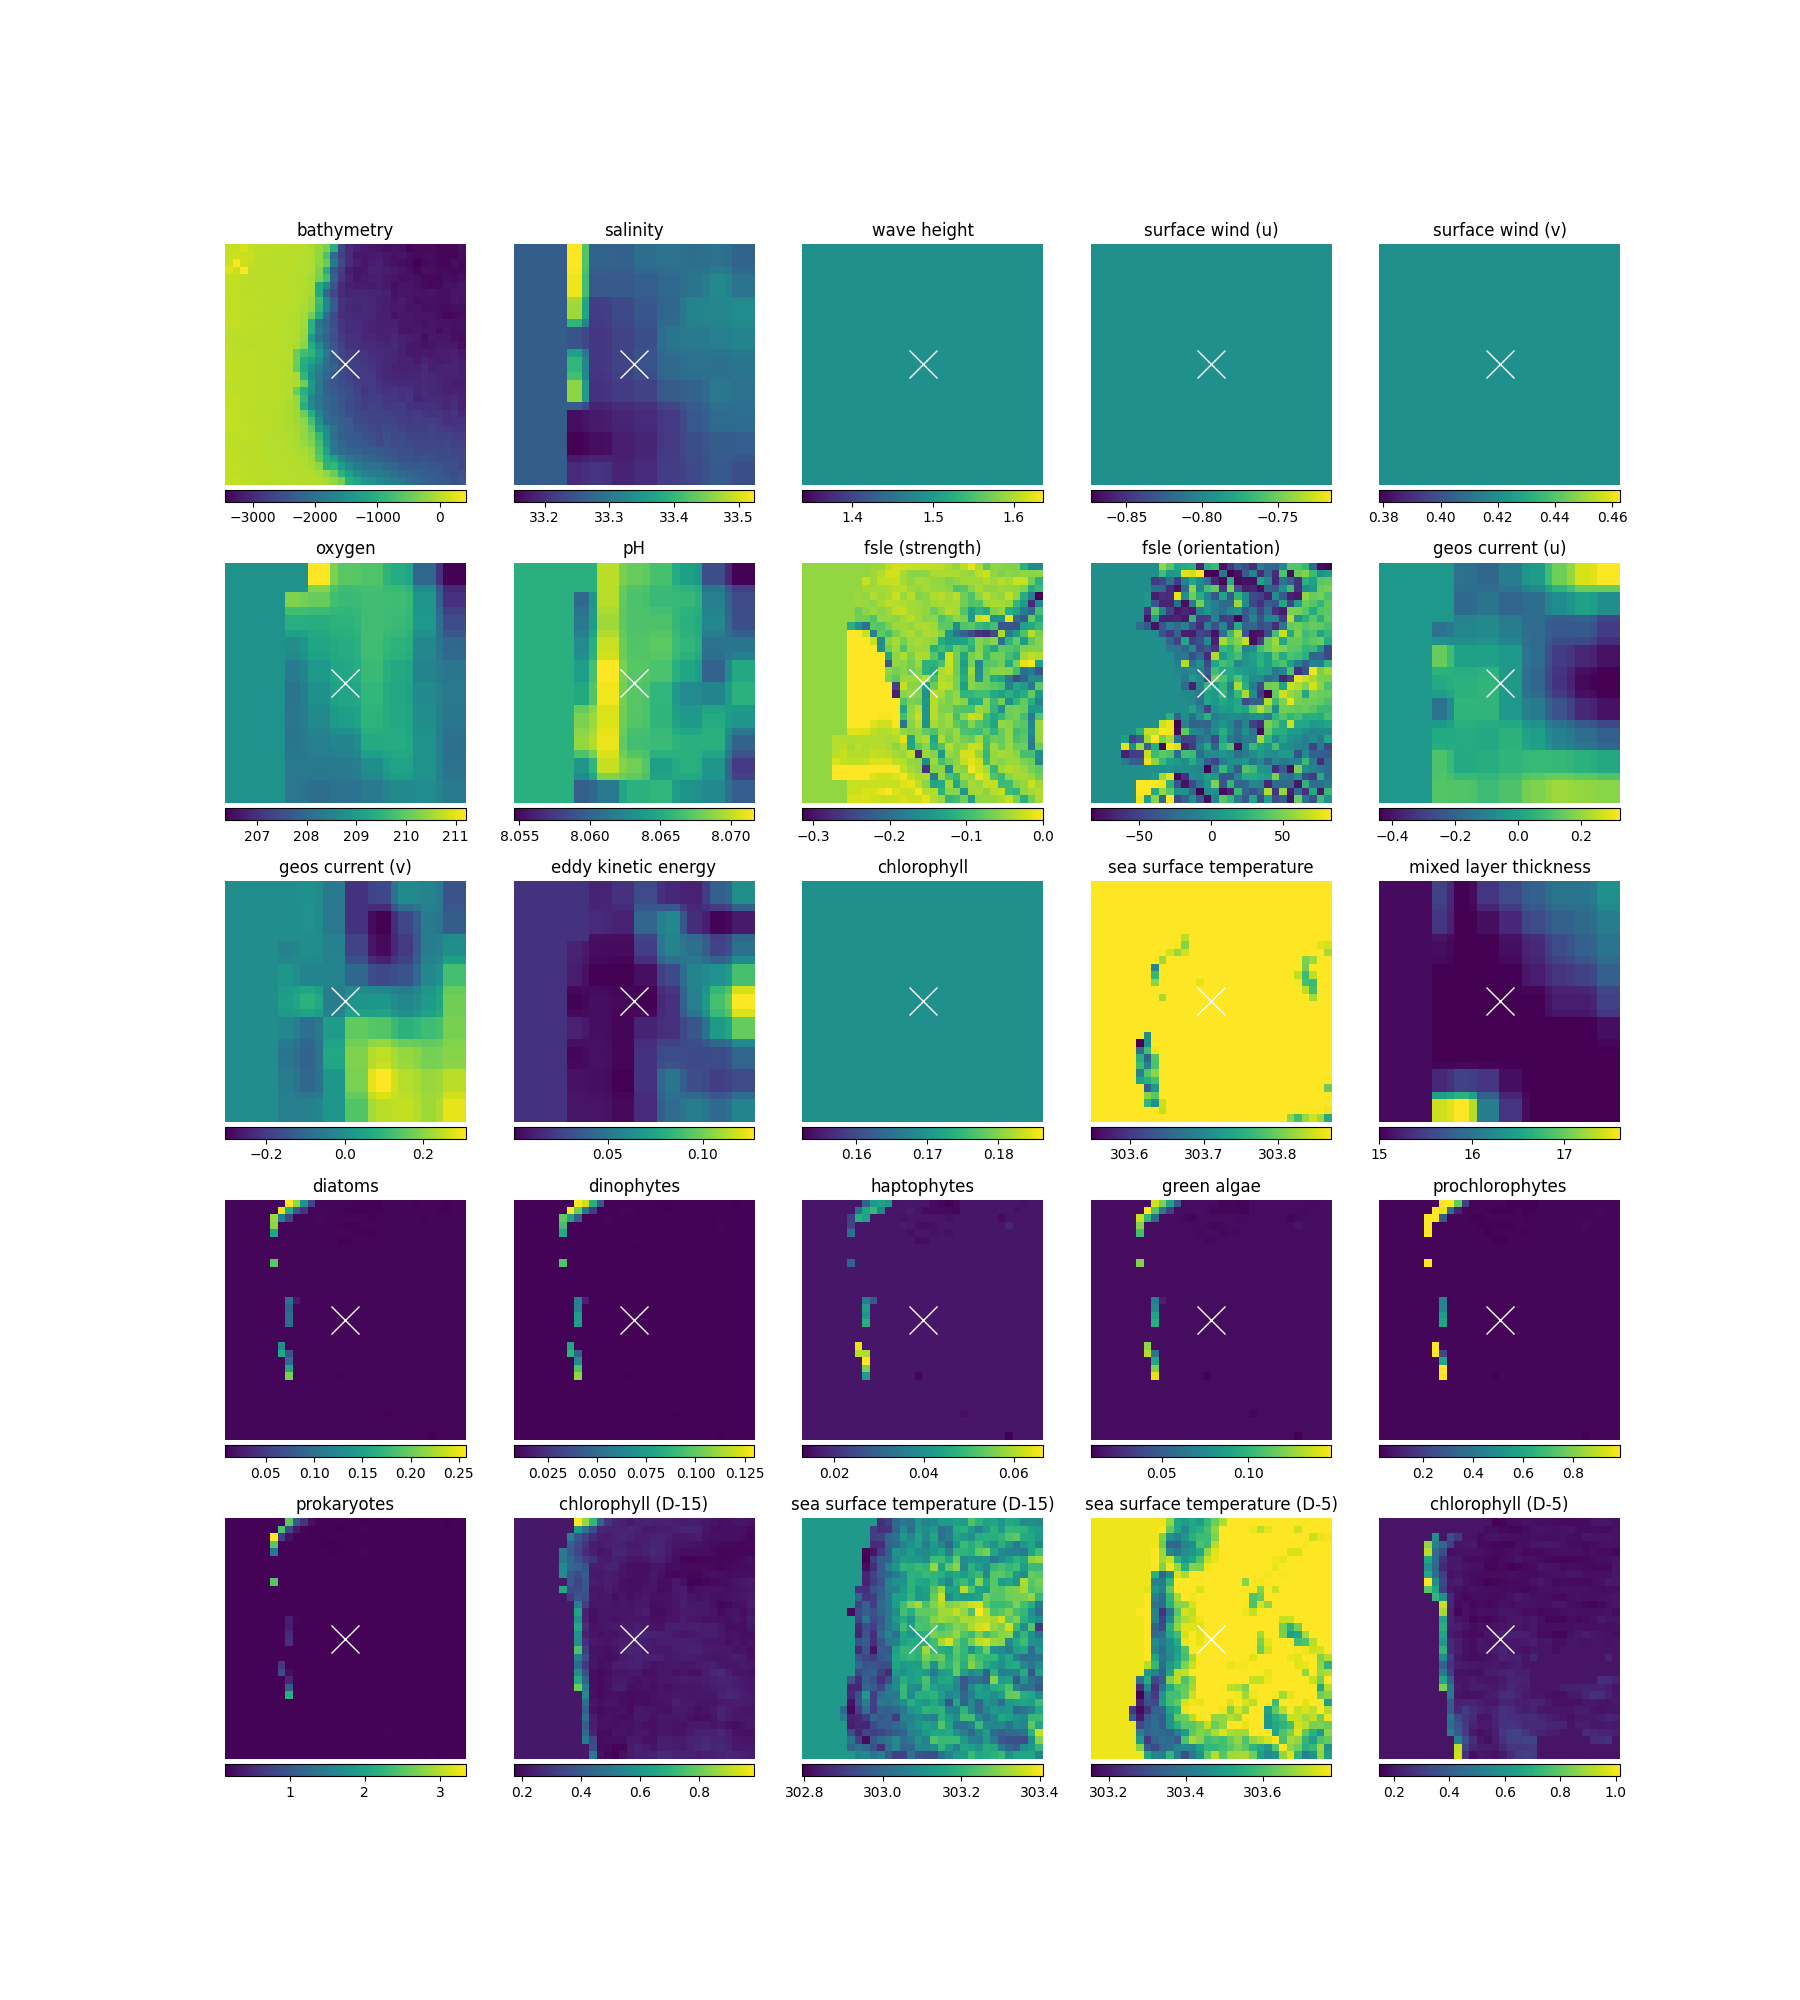

In [67]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib widget

plt.figure(figsize=(18,20))
w, h, _ = real_values.shape

for i in range(real_values.shape[2]):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(real_values[:,:,i], cmap = 'viridis')
    plt.title(labels[i])
    plt.axis('off')
    plt.plot((w-1)/2, (h-1)/2, marker="x", markersize=20, markeredgecolor="white")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    plt.colorbar(cax=cax, location='bottom')

#plt.tight_layout()

    